In [1]:
from pathlib import Path

import cvxpy as cp
import matplotlib.pyplot as plt
import mosek
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

from einops import rearrange, repeat
from scipy.linalg import matmul_toeplitz, toeplitz

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

%load_ext autoreload

In [2]:
%autoreload 2
import utils
import metrics

from utils import YamlParser, Dyan


In [3]:

# set up some directories
data_dir = Path.cwd().parents[1].joinpath('Datasets', 'DYAN')
assert data_dir.exists()

# load configuration
Lasso_config = YamlParser('config.yaml')
names, data = Lasso_config.parse()
# print(names)
dyan_config = data[0]
elastic_net = data[1]

# create the dictionary
dyan = Dyan(data_dir, dyan_config)
# nice_display(dyan.dictionary)

In [ ]:
m = 4
n_poles = 3
D = dyan.dictionary
T = 10
Np = 161
eps = 1e-8

new_data = True

if new_data is True:
    Y, A, C_gt, A_mat = utils.generate_test_data(m, n_poles, Np, D, T, unity_poles=False)
else:
    # load data
    data = np.load('test_data.npz', allow_pickle=True)
    A = data['rows']
    C_gt = data['C'].reshape(1,-1)
    Y = data['y']
    A_mat = data['A']

# normalize matrix
An = [utils.normalize_matrix(A[i]) for i in range(m)]
An = np.array(An)
y_vec = Y.reshape(-1,1)
Yn = (y_vec / np.linalg.norm(y_vec, 2, keepdims=True)).reshape(4,10,1)


In [ ]:

# solve the problem
cos_sim = []
cos_angle = []
euc_dist = []
sum_C = []
answer = []

# gamma = 200
# lambda1 = 0.5
# alpha = utils.find_alpha(A_mat.T, y_vec.T, gamma, lambda1)
# ans = utils.solve_lasso(Yn, An, lambda1, Np, T, alpha, m)

gamma = 100
# gamma = np.linspace(170, 180, 9)

# lambda1 = 0.25
lam = np.linspace(0.3, 0.6, 100)

for lambda1 in lam:
    alpha = utils.find_alpha(A_mat.T, y_vec.T, gamma, lambda1)
    ans = utils.solve_lasso(Yn, An, lambda1, Np, T, alpha, m)
    
    answer.append(ans)
    sim, theta = metrics.similarity(C_gt, ans)
    cos_sim.append(sim)
    cos_angle.append(theta)
    euc_dist.append(metrics.euc_distance(C_gt, ans))


cmax = np.max(answer)
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    ans = answer[i*4]
    metrics.visualize(rearrange(ans, 'h (w c)-> (h w) c', c=Np), str(i*4), cmax, True)
    
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.plot(lam, cos_sim)

plt.subplot(1,3,2)
plt.plot(lam, cos_angle)

plt.subplot(1,3,3)
plt.plot(lam, euc_dist)

In [ ]:
# print(f'Hyperparameters:\nalpha = {alpha} \ngamma = {gamma} \nlambda = {lambda1}')
ans = answer[2]
C_gt = rearrange(C_gt, 'h (w c)-> (h w) c', c=Np)
ans = rearrange(ans, 'h (w c)-> (h w) c', c=Np)

sum = True
cmax =  np.max([np.sum(ans,1), np.sum(C_gt,1)])
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
metrics.visualize(C_gt, 'Ground Truth', cmax, sum)
plt.subplot(1,2,2)
metrics.visualize(ans, 'Predicted', cmax, sum)

In [269]:

m = 4
n_poles = 3
D = dyan.dictionary
T = 10
Np = 161
eps = 1e-8
gamma = 50
lambda1 = 0.5
threshold = 1.62459174e-02
# threshold = 1.01536931e-01
n_tests = 100


results = []
Y_gt = []
C_gt = []
C_pred = []
Y_pred = []

edge = [0]
similiarity = [0]
angle = [0]
distance = [0]


for t in range(n_tests):
    Y, A, C, A_mat = utils.generate_test_data(m, n_poles, Np, D, T, unity_poles=False)
    Y_gt.append(Y)
    C_gt.append(C)
    
    # normalize matrix
    An = [utils.normalize_matrix(A[i]) for i in range(m)]
    An = np.array(An)
    
    Yn = [utils.normalize_matrix(Y[i]) for i in range(m)]
    Yn = np.array(Yn).reshape(m,T,1)
    
    alpha = utils.find_alpha(A, Y, gamma, lambda1)
    C_ = utils.solve_lasso(Y, An, lambda1, Np, T, alpha, m, threshold)
    C_pred.append(C_)
    
    
    sim, theta = metrics.similarity(C, C_)
    similiarity.append(metrics.running_avg(sim, similiarity[t], t+1))
    angle.append(metrics.running_avg(theta, angle[t], t+1))

    distance_acc = metrics.euc_distance(C, C_)
    distance.append(metrics.running_avg(distance_acc, distance[t], t+1))
    
    edge_acc = metrics.edge_accuracy(C, C_)
    edge.append(metrics.running_avg(edge_acc, edge[t], t+1))
    
    # Y_ = np.matmul(D, rearrange(C_, 'h w -> h w 1'))
    # Y_pred.append(Y_)



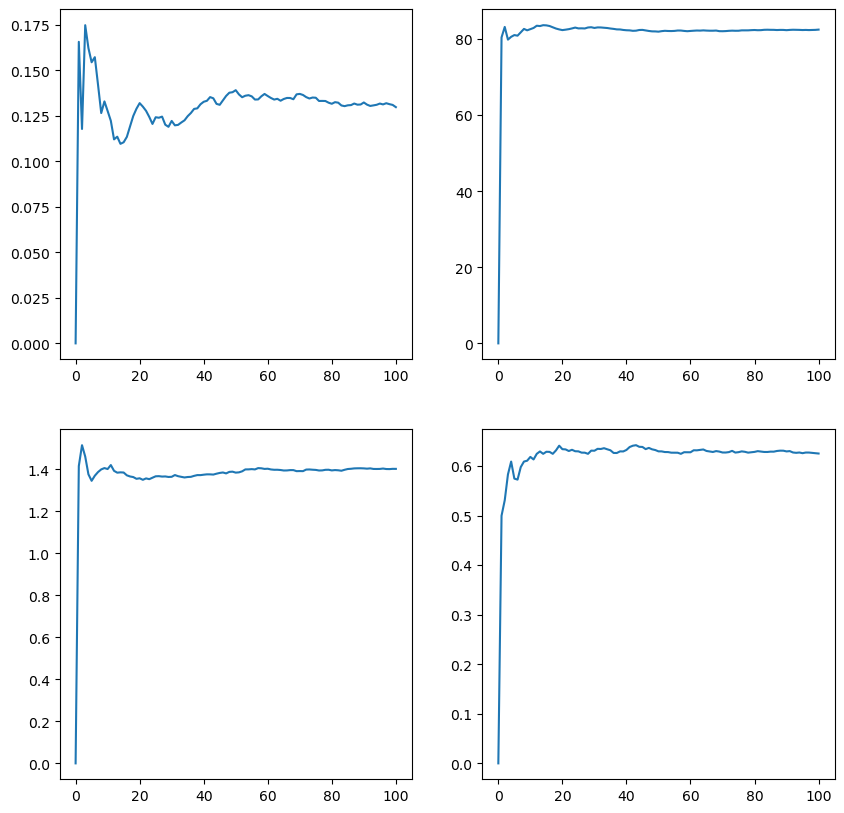

In [270]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(similiarity)

plt.subplot(2,2,2)
plt.plot(angle)

plt.subplot(2,2,3)
plt.plot(distance)

plt.subplot(2,2,4)
plt.plot(edge)